In [190]:
from graphviz import Digraph

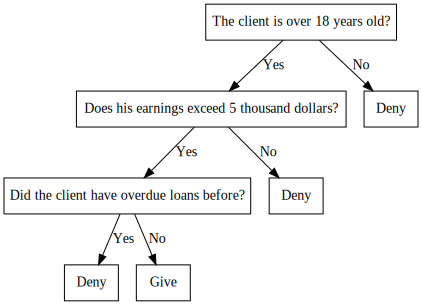

In [191]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='The client is over 18 years old?')
dot.node('B', label='Does his earnings exceed 5 thousand dollars?')
dot.node('C', label='Deny')
dot.node('D', label='Did the client have overdue loans before?')
dot.node('E', label='Deny')
dot.node('F', label='Deny')
dot.node('G', label='Give')

dot.edge('A', 'B', label='Yes')
dot.edge('A', 'C', label='No')
dot.edge('B', 'D', label='Yes')
dot.edge('B', 'E', label='No')
dot.edge('D', 'F', label='Yes')
dot.edge('D', 'G', label='No')

dot

In [192]:
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [193]:
classification_data, classification_labels = datasets.make_classification(
    n_features=2, n_informative=2, n_classes=2, n_redundant=0, n_clusters_per_class=1, random_state=5)

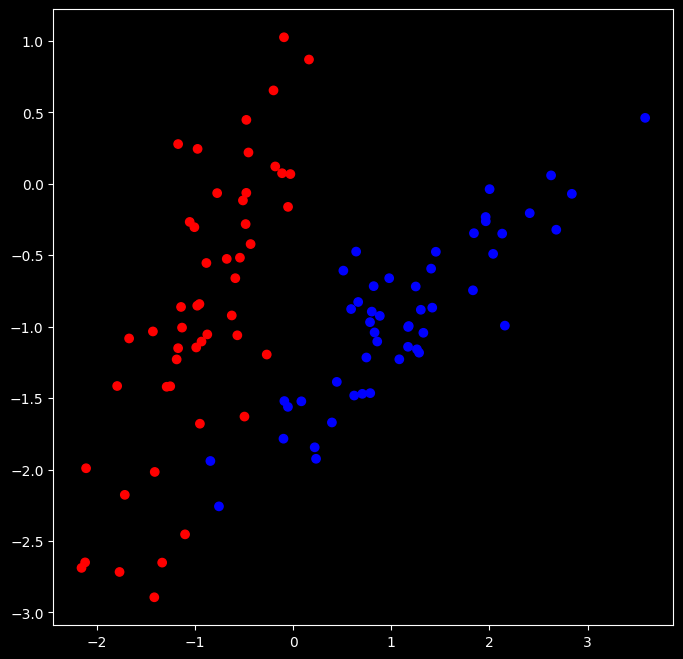

In [194]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0], classification_data[:,1], c=classification_labels, cmap=colors)
plt.show()

In [195]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [196]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {} # {name_class: value of objects}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0

            classes[label] +=1

            # classes.get => return name key with max value  <----
            # Default without key: return max name key
            prediction = max(classes, key=classes.get)
            return prediction

$Gini Impurity = 1 - \sum_{i=1}^{m} p_i^2$

m is the number of classes
p_i is the proportion of the instances belonging to class i in the current node
#
$Gini Coefficient = \frac{\sum_{i=1}^{m} \sum_{j=1}^{m} p_{i} p_{j}}{m-1}$

m is the number of classes
p_i is the proportion of the instances belonging to class i in the current node.

In [197]:
# Gini Impurity it is not Gini impurity!!!
# more is better
def gini_impurity(labels):
    # get counter of every class
    classes = {}
    for label in labels:
        # if class not exist add in classes new class
        if label not in classes:
            classes[label] = 0

        classes[label] += 1

    impurity = 1
    for label in classes:
        # probability = counter of class / all samples
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [198]:
def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini_impurity(left_labels) - (1 - p) * gini_impurity(right_labels)

In [199]:
# split dataset in nodes
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [200]:
def find_best_split(data, labels):
    min_leaf = 5

    current_gini = gini_impurity(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # unique
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [201]:
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [202]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [203]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [204]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

In [205]:
my_tree = build_tree(train_data, train_labels)

In [206]:
# build train tree recursion
def print_tree(node, spacing=''):
    if isinstance(node, Leaf):
        print(spacing + 'Prediction:', node.prediction)
        return

    print(spacing + 'Index', str(node.index))
    print(spacing + 'threshold', str(node.t))

    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + '  ')

    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + '  ')

print_tree(my_tree)

Index 0
threshold 0.16261402870113306
--> True:
  Index 1
  threshold -1.5208896621663803
  --> True:
    Index 0
    threshold -0.9478301462477035
    --> True:
      Prediction: 0
    --> False:
      Prediction: 1
  --> False:
    Prediction: 0
--> False:
  Prediction: 1


In [207]:
# answers
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [208]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1

    return correct / float(len(actual)) * 100.0

In [209]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [210]:
test_accuracy = accuracy_metric(test_labels, test_answers)
test_accuracy

100.0

Text(0.5, 1.0, 'Test accuracy=100.00')

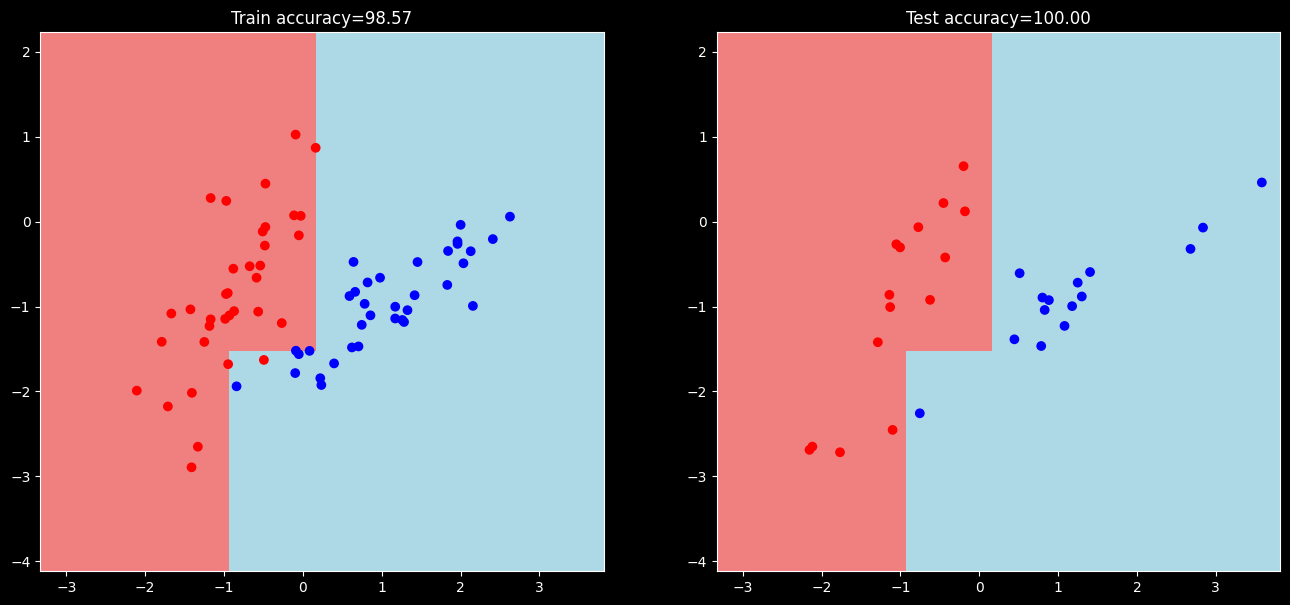

In [211]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min , x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')